In [1]:
# adapted from https://github.com/spmallick/learnopencv/blob/master/OpenPose-Multi-Person/multi-person-openpose.ipynb

import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib

from random import randint

In [2]:
import os

# Set root directory
root_dir = "C:\\Users\\avika\\OneDrive\\Documents\\UAL\\interactive_dance_thesis"
os.chdir(root_dir)

# Check if the current working directory was set correctly
print(os.getcwd())


C:\Users\avika\OneDrive\Documents\UAL\interactive_dance_thesis


In [3]:
device = "gpu" # please change it to "gpu" if the model needs to be run on cuda.

In [4]:
protoFile = "models/openpose_25/pose_deploy.prototxt"
weightsFile = "models/openpose_25/pose_iter_584000.caffemodel"
nPoints = 25

# BODY_25 Keypoints
keypointsMapping = ['Nose', 'Neck', 'R-Sho', 'R-Elb', 'R-Wr', 'L-Sho', 
                    'L-Elb', 'L-Wr', 'MidHip', 'R-Hip', 'R-Knee', 'R-Ank', 
                    'L-Hip', 'L-Knee', 'L-Ank', 'R-Eye', 'L-Eye', 'R-Ear', 
                    'L-Ear', 'L-BigToe', 'L-SmallToe', 'L-Heel', 'R-BigToe', 
                    'R-SmallToe', 'R-Heel']

# Defining the limb connections based on the provided keypoints
# The connections are defined as pairs of indices from the keypoints_list

limb_connections = [
    ("Nose", "Neck"),
    ("Neck", "R-Sho"),
    ("R-Sho", "R-Elb"),
    ("R-Elb", "R-Wr"),
    ("Neck", "L-Sho"),
    ("L-Sho", "L-Elb"),
    ("L-Elb", "L-Wr"),
    ("Neck", "MidHip"),
    ("MidHip", "R-Hip"),
    ("R-Hip", "R-Knee"),
    ("R-Knee", "R-Ank"),
    ("MidHip", "L-Hip"),
    ("L-Hip", "L-Knee"),
    ("L-Knee", "L-Ank"),
    ("Nose", "R-Eye"),
    ("R-Eye", "R-Ear"),
    ("Nose", "L-Eye"),
    ("L-Eye", "L-Ear"),
    ("L-Ank", "L-BigToe"),
    ("L-Ank", "L-SmallToe"),
    ("L-Ank", "L-Heel"),
    ("R-Ank", "R-BigToe"),
    ("R-Ank", "R-SmallToe"),
    ("R-Ank", "R-Heel")
]


# BODY_25 Pose Pairs
POSE_PAIRS = [[1,0], [1,2], [1,5], [2,3], [3,4], [5,6], [6,7], [1,8], [8,12], 
              [8,9], [9,10], [12,13], [13,14], [1,15], [1,16], [0,15], [0,16], 
              [15,17], [16,18], [14,21], [14,19], [19,20], [10,23], [10,22], 
              [22,23]]

# I'm assuming PAF indices based on the order in POSE_PAIRS, but this might need adjustment.
mapIdx = [[0,1], [2,3], [4,5], [6,7], [8,9], [10,11], [12,13], [14,15], [16,17],
          [18,19], [20,21], [22,23], [24,25], [26,27], [28,29], [30,31], [32,33], 
          [34,35], [36,37], [38,39], [40,41], [42,43], [44,45], [46,47], [48,49]]

# Colors for keypoints, added random colors for the 7 new keypoints.
colors = [[0,100,255], [0,100,255], [0,255,255], [0,100,255], [0,255,255], [0,100,255],
          [0,255,0], [255,200,100], [255,0,255], [0,255,0], [255,200,100], [255,0,255],
          [0,0,255], [255,0,0], [200,200,0], [255,0,0], [200,200,0], [0,0,0],
          [255,255,0], [200,0,200], [0,200,200], [255,100,100], [100,255,100], 
          [100,100,255], [255,50,50]]


In [5]:
# Find the Keypoints using Non Maximum Suppression on the Confidence Map
def getKeypoints(probMap, threshold=0.1):
    
    mapSmooth = cv2.GaussianBlur(probMap,(3,3),0,0)

    mapMask = np.uint8(mapSmooth>threshold)
    keypoints = []
    
    #find the blobs
    contours, _ = cv2.findContours(mapMask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    #for each blob find the maxima
    for cnt in contours:
        blobMask = np.zeros(mapMask.shape)
        blobMask = cv2.fillConvexPoly(blobMask, cnt, 1)
        maskedProbMap = mapSmooth * blobMask
        _, maxVal, _, maxLoc = cv2.minMaxLoc(maskedProbMap)
        keypoints.append(maxLoc + (probMap[maxLoc[1], maxLoc[0]],))

    return keypoints


## Use the following equation for finding valid joint-pairs

![](./pose-estimation-paf-equation.png)

In the above equation:

L is the PAF;

d is the vector joining two joints;

p is the interpolated point between two joints;

It is implemented using the dot product between the PAF and the vector $d_{ij}$

In [6]:
# Find valid connections between the different joints of a all persons present
def getValidPairs(output):
    valid_pairs = []
    invalid_pairs = []
    n_interp_samples = 10
    paf_score_th = 0.05
    conf_th = 0.6
    # loop for every POSE_PAIR
    for k in range(len(mapIdx)):
        # A->B constitute a limb
        pafA = output[0, mapIdx[k][0], :, :]
        pafB = output[0, mapIdx[k][1], :, :]
        pafA = cv2.resize(pafA, (frameWidth, frameHeight))
        pafB = cv2.resize(pafB, (frameWidth, frameHeight))

        # Find the keypoints for the first and second limb
        candA = detected_keypoints[POSE_PAIRS[k][0]]
        candB = detected_keypoints[POSE_PAIRS[k][1]]
        nA = len(candA)
        nB = len(candB)

        # If keypoints for the joint-pair is detected
        # check every joint in candA with every joint in candB 
        # Calculate the distance vector between the two joints
        # Find the PAF values at a set of interpolated points between the joints
        # Use the above formula to compute a score to mark the connection valid
        
        if( nA != 0 and nB != 0):
            valid_pair = np.zeros((0,3))
            for i in range(nA):
                max_j=-1
                maxScore = -1
                found = 0
                for j in range(nB):
                    # Find d_ij
                    d_ij = np.subtract(candB[j][:2], candA[i][:2])
                    norm = np.linalg.norm(d_ij)
                    if norm:
                        d_ij = d_ij / norm
                    else:
                        continue
                    # Find p(u)
                    interp_coord = list(zip(np.linspace(candA[i][0], candB[j][0], num=n_interp_samples),
                                            np.linspace(candA[i][1], candB[j][1], num=n_interp_samples)))
                    # Find L(p(u))
                    paf_interp = []
                    for k in range(len(interp_coord)):
                        paf_interp.append([pafA[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))],
                                           pafB[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))] ]) 
                    # Find E
                    paf_scores = np.dot(paf_interp, d_ij)
                    avg_paf_score = sum(paf_scores)/len(paf_scores)
                    
                    # Check if the connection is valid
                    # If the fraction of interpolated vectors aligned with PAF is higher then threshold -> Valid Pair  
                    if ( len(np.where(paf_scores > paf_score_th)[0]) / n_interp_samples ) > conf_th :
                        if avg_paf_score > maxScore:
                            max_j = j
                            maxScore = avg_paf_score
                            found = 1
                # Append the connection to the list
                if found:            
                    valid_pair = np.append(valid_pair, [[candA[i][3], candB[max_j][3], maxScore]], axis=0)

            # Append the detected connections to the global list
            valid_pairs.append(valid_pair)
        else: # If no keypoints are detected
            print("No Connection : k = {}".format(k))
            invalid_pairs.append(k)
            valid_pairs.append([])
    print(valid_pairs)
    return valid_pairs, invalid_pairs


In [7]:
# This function creates a list of keypoints belonging to each person
# For each detected valid pair, it assigns the joint(s) to a person
# It finds the person and index at which the joint should be added. This can be done since we have an id for each joint
def getPersonwiseKeypoints(valid_pairs, invalid_pairs, nPoints = nPoints):
    # the last number in each row is the overall score 
    personwiseKeypoints = -1 * np.ones((0, nPoints+1))

    for k in range(len(mapIdx)):
        if k not in invalid_pairs:
            partAs = valid_pairs[k][:,0]
            partBs = valid_pairs[k][:,1]
            indexA, indexB = np.array(POSE_PAIRS[k])

            for i in range(len(valid_pairs[k])): 
                found = 0
                person_idx = -1
                for j in range(len(personwiseKeypoints)):
                    if personwiseKeypoints[j][indexA] == partAs[i]:
                        person_idx = j
                        found = 1
                        break

                if found:
                    personwiseKeypoints[person_idx][indexB] = partBs[i]
                    personwiseKeypoints[person_idx][-1] += keypoints_list[partBs[i].astype(int), 2] + valid_pairs[k][i][2]

                # if find no partA in the subset, create a new subset
                elif not found and k < 17:
                    row = -1 * np.ones(nPoints+1)
                    row[indexA] = partAs[i]
                    row[indexB] = partBs[i]
                    # add the keypoint_scores for the two keypoints and the paf_score 
                    row[-1] = sum(keypoints_list[valid_pairs[k][i,:2].astype(int), 2]) + valid_pairs[k][i][2]
                    personwiseKeypoints = np.vstack([personwiseKeypoints, row])
    return personwiseKeypoints

In [9]:
image1 = cv2.imread("data/test_3.png")
frameWidth = image1.shape[1]
frameHeight = image1.shape[0]

#### Load the network and pass the image through the network

In [26]:
t = time.time()
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

if device == "cpu":
    net.setPreferableBackend(cv2.dnn.DNN_TARGET_CPU)
    print("Using CPU device")
elif device == "gpu":
    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)
    print("Using GPU device")

# Fix the input Height and get the width according to the Aspect Ratio
inHeight = 368
inWidth = int((inHeight/frameHeight)*frameWidth)

inpBlob = cv2.dnn.blobFromImage(image1, 1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)

net.setInput(inpBlob)
output = net.forward()
print("Time Taken = {}".format(time.time() - t))

Using GPU device
Time Taken = 0.941237211227417


#### Slice a probability map ( for e.g Nose ) from the output for a specific keypoint and plot the heatmap ( after resizing ) on the image itself

(-0.5, 970.5, 674.5, -0.5)

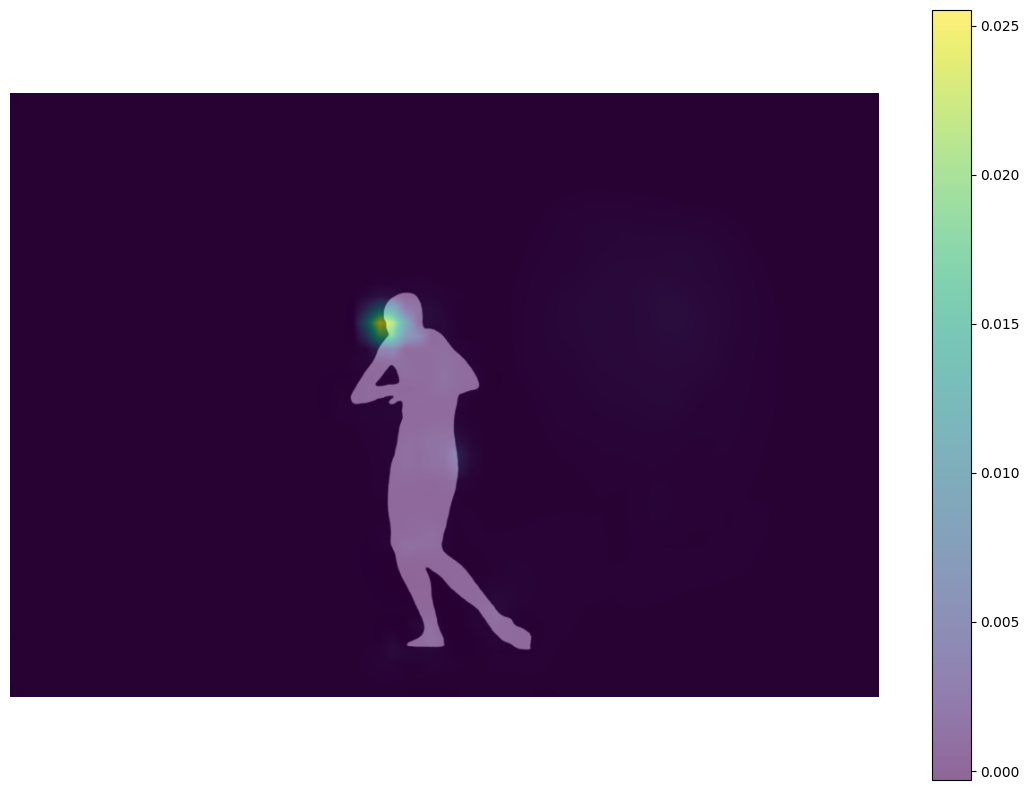

In [11]:
i = 0
probMap = output[0, i, :, :]
probMap = cv2.resize(probMap, (frameWidth, frameHeight))
plt.figure(figsize=[14,10])
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.imshow(probMap, alpha=0.6)
plt.colorbar()
plt.axis("off")

In [12]:
detected_keypoints = []
keypoints_body_map = {}

keypoints_list = np.zeros((0,3))
keypoint_id = 0
threshold = 0.1

for part in range(nPoints):
    probMap = output[0,part,:,:]
    probMap = cv2.resize(probMap, (image1.shape[1], image1.shape[0]))
#     plt.figure()
#     plt.imshow(255*np.uint8(probMap>threshold))
    keypoints = getKeypoints(probMap, threshold)
    print("Keypoints - {} : {}".format(keypointsMapping[part], keypoints))
    keypoints_body_map[keypointsMapping[part]] = keypoints
    keypoints_with_id = []
    for i in range(len(keypoints)):
        keypoints_with_id.append(keypoints[i] + (keypoint_id,))
        keypoints_list = np.vstack([keypoints_list, keypoints[i]])
        keypoint_id += 1

    detected_keypoints.append(keypoints_with_id)


Keypoints - Nose : []
Keypoints - Neck : [(442, 272, 0.67933375)]
Keypoints - R-Sho : [(471, 271, 0.79393077)]
Keypoints - R-Elb : [(500, 315, 0.55895966)]
Keypoints - R-Wr : [(470, 331, 0.18732736)]
Keypoints - L-Sho : [(426, 285, 0.7036862)]
Keypoints - L-Elb : [(384, 330, 0.7382324)]
Keypoints - L-Wr : [(427, 330, 0.5246308)]
Keypoints - MidHip : [(456, 403, 0.55580443)]
Keypoints - R-Hip : [(471, 403, 0.42004186)]
Keypoints - R-Knee : [(442, 506, 0.5159296)]
Keypoints - R-Ank : [(470, 594, 0.39367878), (530, 579, 0.13079898)]
Keypoints - L-Hip : [(455, 404, 0.4883053)]
Keypoints - L-Knee : [(443, 506, 0.5337208)]
Keypoints - L-Ank : [(469, 594, 0.2604927), (542, 580, 0.307274)]
Keypoints - R-Eye : []
Keypoints - L-Eye : []
Keypoints - R-Ear : [(455, 242, 0.30495867)]
Keypoints - L-Ear : [(426, 256, 0.49648356)]
Keypoints - L-BigToe : [(440, 609, 0.25556612), (558, 608, 0.18897395)]
Keypoints - L-SmallToe : [(442, 622, 0.2690685), (558, 595, 0.21331212)]
Keypoints - L-Heel : [(471, 

In [13]:
keypoints_body_map

{'Nose': [],
 'Neck': [(442, 272, 0.67933375)],
 'R-Sho': [(471, 271, 0.79393077)],
 'R-Elb': [(500, 315, 0.55895966)],
 'R-Wr': [(470, 331, 0.18732736)],
 'L-Sho': [(426, 285, 0.7036862)],
 'L-Elb': [(384, 330, 0.7382324)],
 'L-Wr': [(427, 330, 0.5246308)],
 'MidHip': [(456, 403, 0.55580443)],
 'R-Hip': [(471, 403, 0.42004186)],
 'R-Knee': [(442, 506, 0.5159296)],
 'R-Ank': [(470, 594, 0.39367878), (530, 579, 0.13079898)],
 'L-Hip': [(455, 404, 0.4883053)],
 'L-Knee': [(443, 506, 0.5337208)],
 'L-Ank': [(469, 594, 0.2604927), (542, 580, 0.307274)],
 'R-Eye': [],
 'L-Eye': [],
 'R-Ear': [(455, 242, 0.30495867)],
 'L-Ear': [(426, 256, 0.49648356)],
 'L-BigToe': [(440, 609, 0.25556612), (558, 608, 0.18897395)],
 'L-SmallToe': [(442, 622, 0.2690685), (558, 595, 0.21331212)],
 'L-Heel': [(471, 608, 0.31606695), (544, 593, 0.23732628)],
 'R-BigToe': [(440, 610, 0.30886522)],
 'R-SmallToe': [(440, 609, 0.30679643)],
 'R-Heel': [(471, 608, 0.30370358)]}

In [14]:
valid_pairs, invalid_pairs = getValidPairs(output)

No Connection : k = 0
No Connection : k = 13
No Connection : k = 14
No Connection : k = 15
No Connection : k = 16
No Connection : k = 17
No Connection : k = 18
[[], array([[0.        , 1.        , 0.45848228]]), array([[0.       , 4.       , 0.2964028]]), array([], shape=(0, 3), dtype=float64), array([], shape=(0, 3), dtype=float64), array([], shape=(0, 3), dtype=float64), array([], shape=(0, 3), dtype=float64), array([], shape=(0, 3), dtype=float64), array([], shape=(0, 3), dtype=float64), array([], shape=(0, 3), dtype=float64), array([], shape=(0, 3), dtype=float64), array([], shape=(0, 3), dtype=float64), array([[13.        , 14.        ,  0.81878269]]), [], [], [], [], [], [], array([[14.        , 22.        ,  0.3075939 ],
       [15.        , 23.        ,  0.28363758]]), array([], shape=(0, 3), dtype=float64), array([], shape=(0, 3), dtype=float64), array([], shape=(0, 3), dtype=float64), array([], shape=(0, 3), dtype=float64), array([], shape=(0, 3), dtype=float64)]


In [15]:
personwiseKeypoints = getPersonwiseKeypoints(valid_pairs, invalid_pairs)

In [16]:
keypoints_body_map

{'Nose': [],
 'Neck': [(442, 272, 0.67933375)],
 'R-Sho': [(471, 271, 0.79393077)],
 'R-Elb': [(500, 315, 0.55895966)],
 'R-Wr': [(470, 331, 0.18732736)],
 'L-Sho': [(426, 285, 0.7036862)],
 'L-Elb': [(384, 330, 0.7382324)],
 'L-Wr': [(427, 330, 0.5246308)],
 'MidHip': [(456, 403, 0.55580443)],
 'R-Hip': [(471, 403, 0.42004186)],
 'R-Knee': [(442, 506, 0.5159296)],
 'R-Ank': [(470, 594, 0.39367878), (530, 579, 0.13079898)],
 'L-Hip': [(455, 404, 0.4883053)],
 'L-Knee': [(443, 506, 0.5337208)],
 'L-Ank': [(469, 594, 0.2604927), (542, 580, 0.307274)],
 'R-Eye': [],
 'L-Eye': [],
 'R-Ear': [(455, 242, 0.30495867)],
 'L-Ear': [(426, 256, 0.49648356)],
 'L-BigToe': [(440, 609, 0.25556612), (558, 608, 0.18897395)],
 'L-SmallToe': [(442, 622, 0.2690685), (558, 595, 0.21331212)],
 'L-Heel': [(471, 608, 0.31606695), (544, 593, 0.23732628)],
 'R-BigToe': [(440, 610, 0.30886522)],
 'R-SmallToe': [(440, 609, 0.30679643)],
 'R-Heel': [(471, 608, 0.30370358)]}

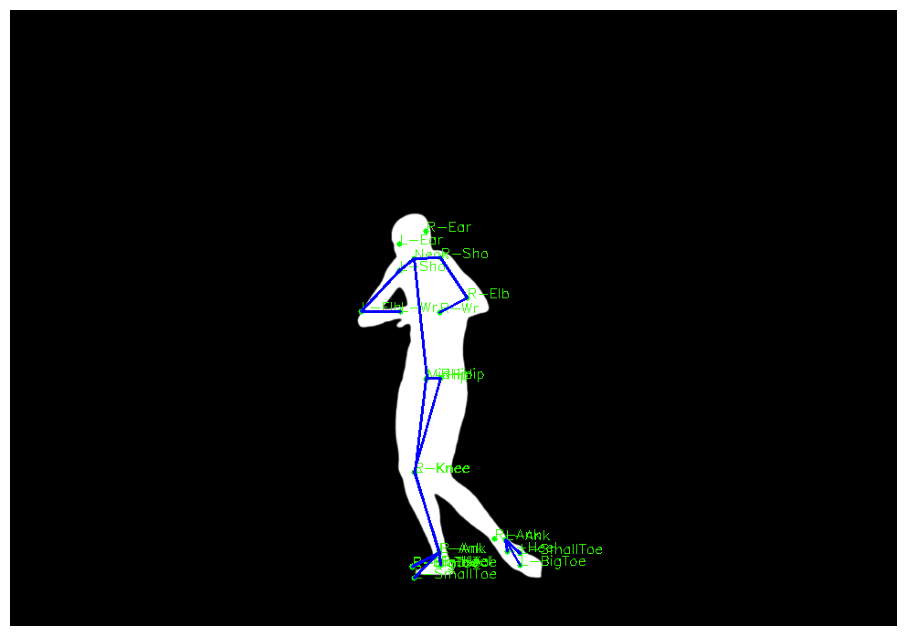

In [17]:
# Adjusting the visualization function to connect keypoints that are likely to belong to the same person

from collections import defaultdict

frameClone = image1.copy()

def create_skeletons(start_name, end_name ):
    """ Assign keypoints to person. Closest points likely to be from the same person. But same bodypart cannot be connected to the the same bodypart twice"""
    distance_map = defaultdict(dict)
    i = 0
    for start_pt in keypoints_body_map[start_name]:
        k=0
        for end_pt in keypoints_body_map[end_name]:
            distance = np.sqrt((start_pt[0] - end_pt[0])**2 + (start_pt[1] - end_pt[1])**2)
            distance_map[(f"{start_name}_{i}", f"{end_name}_{k}")] = {'start_pt': start_pt, 'end_pt': end_pt, 'distance': distance}
            k=k+1
        i = i + 1


    # pick closest distance, but if there are multiple people same bodypart cannot be connected to the same bodypart twice
    # First, we'll initialize our resultant dictionary as empty
    resultant_dict = {}

    # min number of parts, so unique connections only
    num_min_parts = min(len(keypoints_body_map[start_name]), len(keypoints_body_map[end_name])) 
    
    # We'll continue picking pairs until we've picked half the number of pairs in the original data
    while len(resultant_dict) < num_min_parts :
        # Sorting the data by distance and picking the pair with the lowest distance
        sorted_data = sorted(distance_map.items(), key=lambda x: x[1]['distance'])
        
        current_pick = sorted_data[0]
        
  
        # Adding the picked pair to the resultant dictionary
        resultant_dict[current_pick[0]] = current_pick[1]
        
        # Removing the picked pair from the original data
        del distance_map[current_pick[0]]
        
        # Removing entries containing the same body parts as the current pick
        keys_to_remove = [key for key in distance_map if current_pick[0][0] in key or current_pick[0][1] in key]
    

        for key in keys_to_remove:
            del distance_map[key]
            
        
    return resultant_dict

def refined_visualize_skeleton(image, keypoints_dict, connections):
    img = image.copy()
    
    # Draw keypoints
    for k,v in keypoints_dict.items():
        for idx, val in enumerate(v):
            x,y,conf = val
        
            cv2.circle(img, (int(x), int(y)), 3, (0, 255, 0), -1)
            cv2.putText(img, f"{k}", ((int(x)), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 50),1)
            
    
    
    # Draw limb connections
    for start_name, end_name in connections:
        connections_dict = create_skeletons(start_name, end_name)
        for k,v in connections_dict.items():
            start_pt = v['start_pt']
            end_pt = v['end_pt']
            cv2.line(img, (int(start_pt[0]), int(start_pt[1])), (int(end_pt[0]), int(end_pt[1])), (255, 0, 0), 2)
        
    
    return img

# Testing the refined visualization on a blank canvas
visualized_img = refined_visualize_skeleton(frameClone, keypoints_body_map, limb_connections)

plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(visualized_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


In [2]:
import cv2
import numpy as np
from tqdm import tqdm
from IPython.display import display, Image

# Load pre-trained OpenPose model

protoFile = "models/openpose_25/pose_deploy.prototxt"
weightsFile = "models/openpose_25/pose_iter_584000.caffemodel"
nPoints = 25

# BODY_25 Keypoints
keypointsMapping = ['Nose', 'Neck', 'R-Sho', 'R-Elb', 'R-Wr', 'L-Sho', 
                    'L-Elb', 'L-Wr', 'MidHip', 'R-Hip', 'R-Knee', 'R-Ank', 
                    'L-Hip', 'L-Knee', 'L-Ank', 'R-Eye', 'L-Eye', 'R-Ear', 
                    'L-Ear', 'L-BigToe', 'L-SmallToe', 'L-Heel', 'R-BigToe', 
                    'R-SmallToe', 'R-Heel']

# Defining the limb connections based on the provided keypoints
# The connections are defined as pairs of indices from the keypoints_list

limb_connections = [
    ("Nose", "Neck"),
    ("Neck", "R-Sho"),
    ("R-Sho", "R-Elb"),
    ("R-Elb", "R-Wr"),
    ("Neck", "L-Sho"),
    ("L-Sho", "L-Elb"),
    ("L-Elb", "L-Wr"),
    ("Neck", "MidHip"),
    ("MidHip", "R-Hip"),
    ("R-Hip", "R-Knee"),
    ("R-Knee", "R-Ank"),
    ("MidHip", "L-Hip"),
    ("L-Hip", "L-Knee"),
    ("L-Knee", "L-Ank"),
    ("Nose", "R-Eye"),
    ("R-Eye", "R-Ear"),
    ("Nose", "L-Eye"),
    ("L-Eye", "L-Ear"),
    ("L-Ank", "L-BigToe"),
    ("L-Ank", "L-SmallToe"),
    ("L-Ank", "L-Heel"),
    ("R-Ank", "R-BigToe"),
    ("R-Ank", "R-SmallToe"),
    ("R-Ank", "R-Heel")
]


# BODY_25 Pose Pairs
POSE_PAIRS = [[1,0], [1,2], [1,5], [2,3], [3,4], [5,6], [6,7], [1,8], [8,12], 
              [8,9], [9,10], [12,13], [13,14], [1,15], [1,16], [0,15], [0,16], 
              [15,17], [16,18], [14,21], [14,19], [19,20], [10,23], [10,22], 
              [22,23]]

# I'm assuming PAF indices based on the order in POSE_PAIRS, but this might need adjustment.
mapIdx = [[0,1], [2,3], [4,5], [6,7], [8,9], [10,11], [12,13], [14,15], [16,17],
          [18,19], [20,21], [22,23], [24,25], [26,27], [28,29], [30,31], [32,33], 
          [34,35], [36,37], [38,39], [40,41], [42,43], [44,45], [46,47], [48,49]]

# Colors for keypoints, added random colors for the 7 new keypoints.
colors = [[0,100,255], [0,100,255], [0,255,255], [0,100,255], [0,255,255], [0,100,255],
          [0,255,0], [255,200,100], [255,0,255], [0,255,0], [255,200,100], [255,0,255],
          [0,0,255], [255,0,0], [200,200,0], [255,0,0], [200,200,0], [0,0,0],
          [255,255,0], [200,0,200], [0,200,200], [255,100,100], [100,255,100], 
          [100,100,255], [255,50,50]]

threshold = 0.0

def draw_pose(frame, keypoints, threshold=0.1):
    for pair in POSE_PAIRS:
        partA = pair[0]
        partB = pair[1]
        if keypoints[partA] and keypoints[partB]:
            cv2.line(frame, keypoints[partA], keypoints[partB], (0, 255, 255), 2)
            cv2.circle(frame, keypoints[partA], 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)
            cv2.circle(frame, keypoints[partB], 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)
    return frame



def get_pose_keypoints(frame):
    frame_width = frame.shape[1]
    frame_height = frame.shape[0]
    
    inHeight = 368
    inWidth = int((inHeight/frameHeight)*frameWidth)
    inp_blob = cv2.dnn.blobFromImage(image1, 1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)
    net.setInput(inp_blob)
    output = net.forward()
    keypoints = []
    for i in range(nPoints):
        prob_map = output[0, i, :, :]
        min_val, prob, min_loc, point = cv2.minMaxLoc(prob_map)
        x = (frame_width * point[0]) / output.shape[3]
        y = (frame_height * point[1]) / output.shape[2]
        if prob > threshold:
            keypoints.append((int(x), int(y)))
        else:
            keypoints.append(None)
    return keypoints

def process_video(input_path, output_path, resize_factor=1.0):
    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return
    


    frame_width = int(cap.get(3) * resize_factor)
    frame_height = int(cap.get(4) * resize_factor)
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

    processed_frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_resized = cv2.resize(frame, (frame_width, frame_height))
        keypoints = get_pose_keypoints(frame_resized)
        output_frame = draw_pose(frame_resized.copy(), keypoints, threshold)
        
        out.write(output_frame)
        processed_frames.append(output_frame)

    cap.release()
    out.release()
    cv2.destroyAllWindows()

    return processed_frames

# Set the paths to your video file and output file
input_video_path = "G:\\UAL_Thesis\\affective_computing_datasets\\DanceDBrenders\\DanceDB\\20131001_OliviaKyriakides\\Olivia_Excited_C3D_body.mp4"
output_video_path = "output.mp4"

# Process the video and get processed frames
processed_frames = process_video(input_video_path, output_video_path)

# Display some of the processed frames
for frame in processed_frames[::len(processed_frames)//5]:  # Select 5 frames evenly spaced throughout the video
    display(Image(cv2.imencode('.png', cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))[1].tobytes()))


NameError: name 'frameHeight' is not defined

Processing Video: 100%|██████████| 1119/1119 [04:46<00:00,  3.91frame/s]


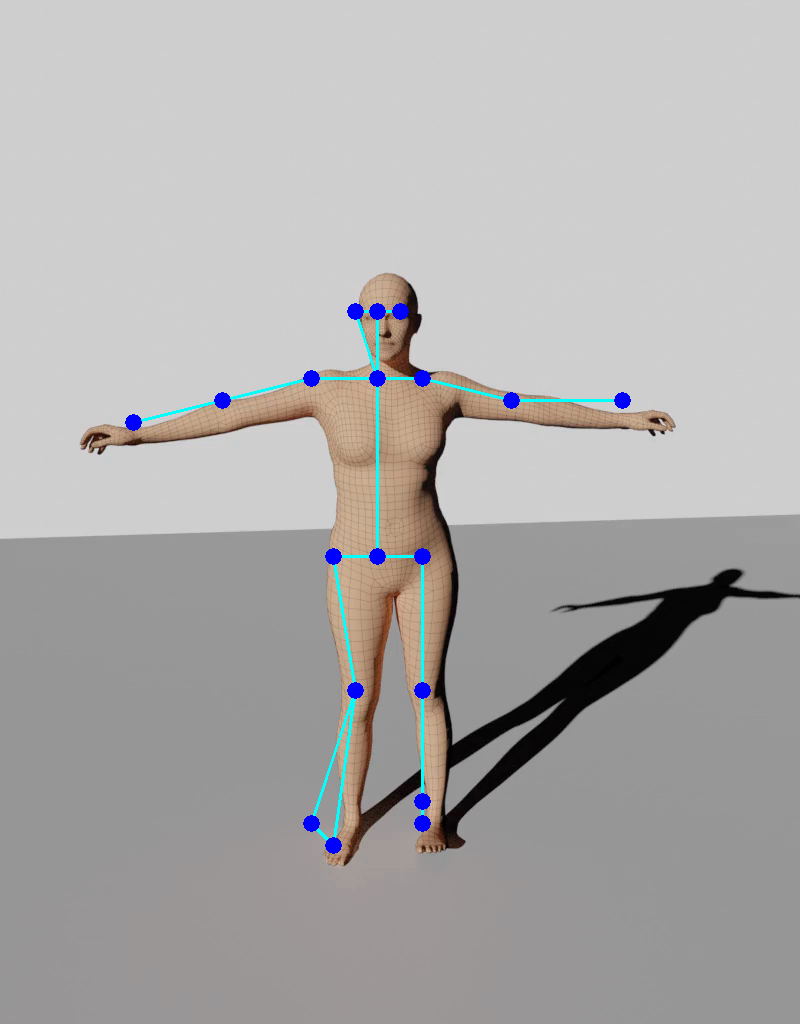

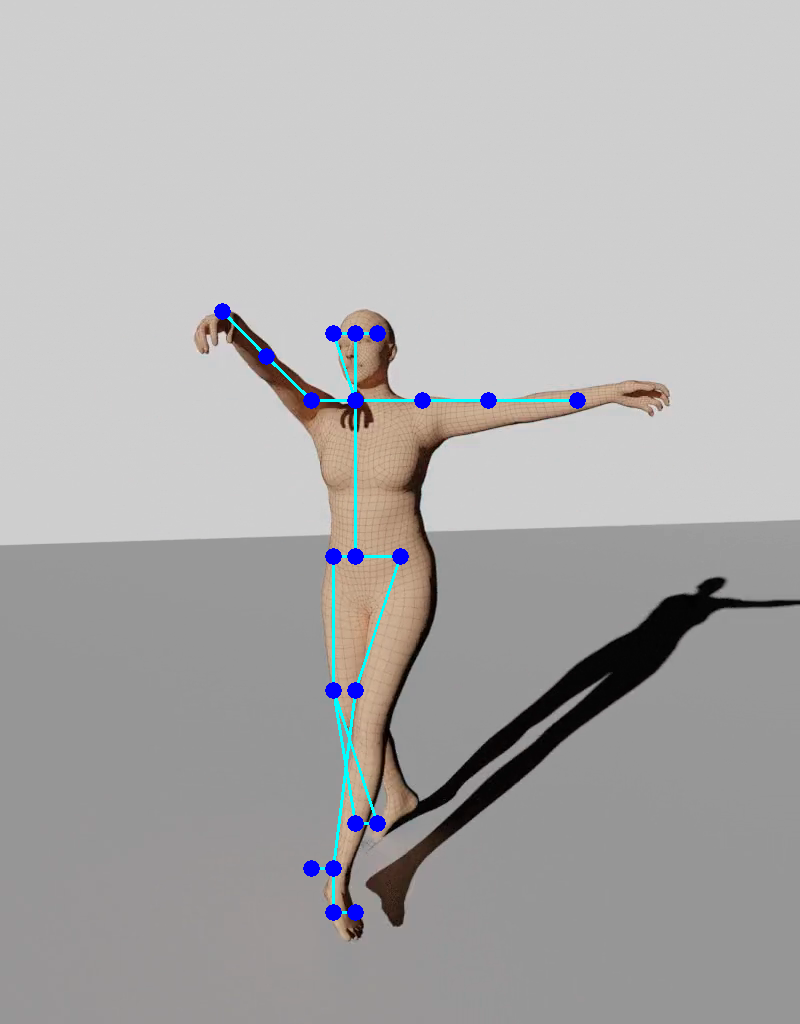

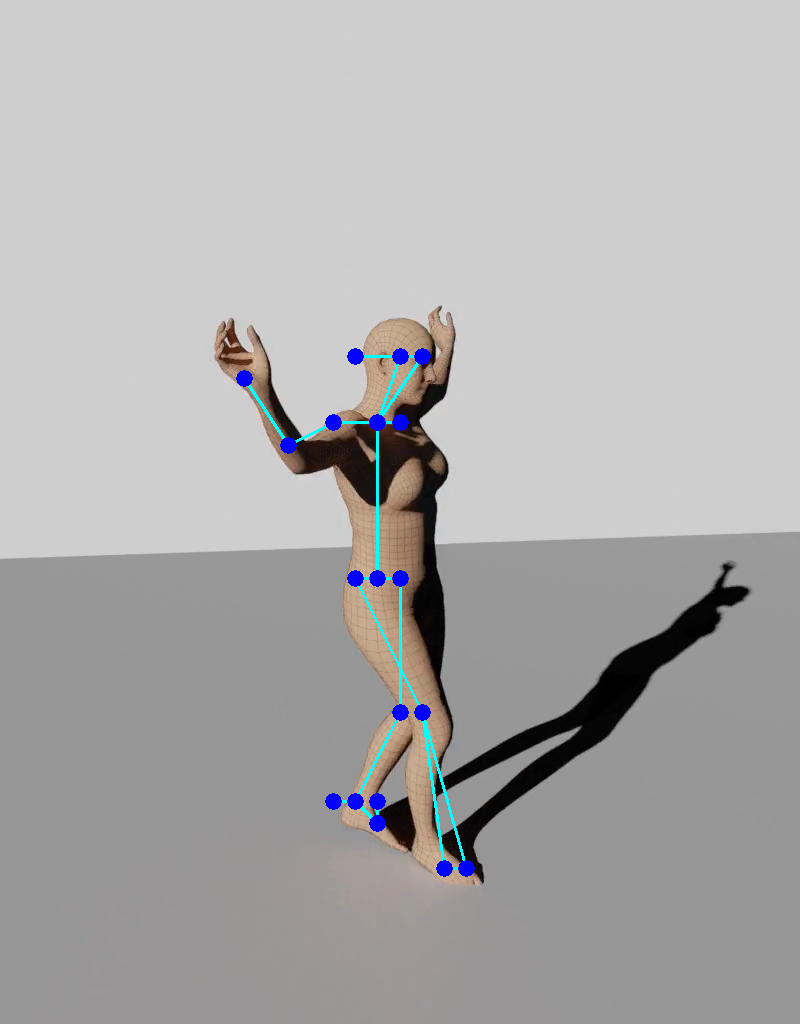

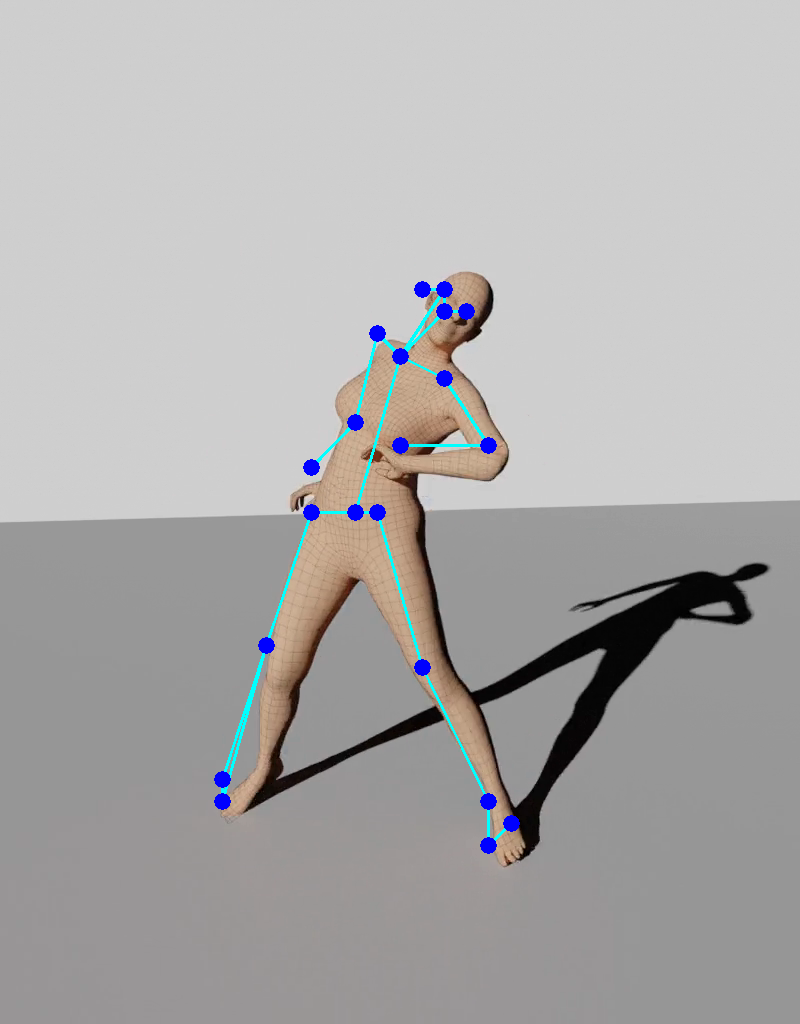

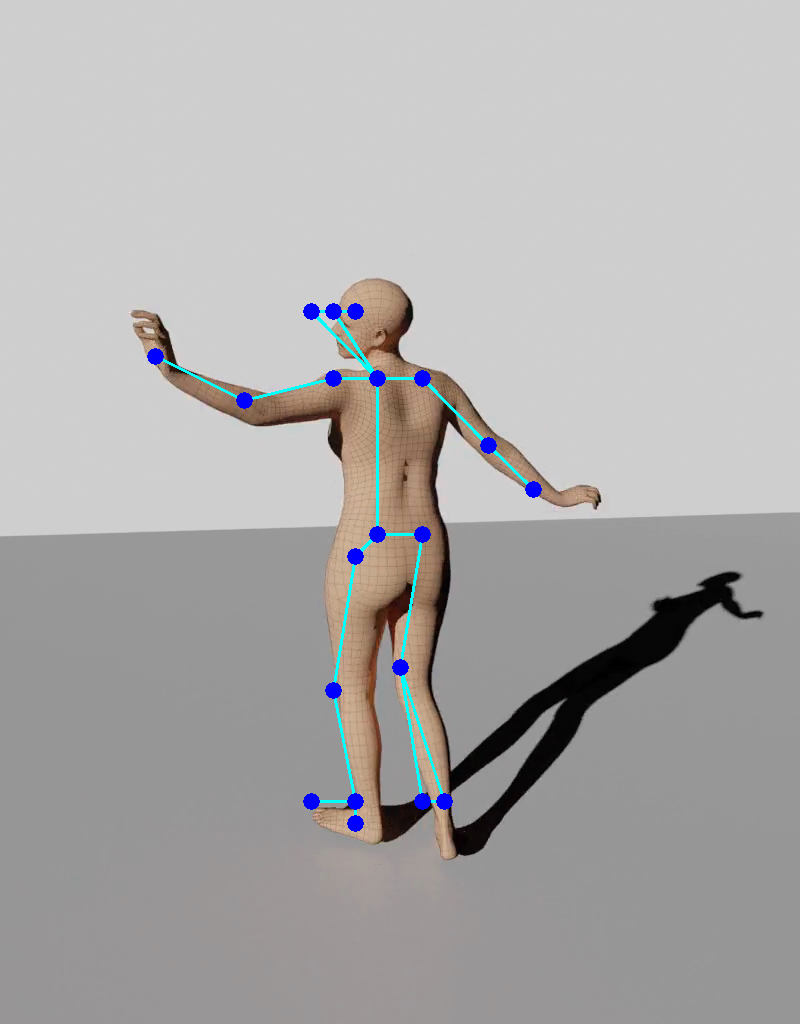

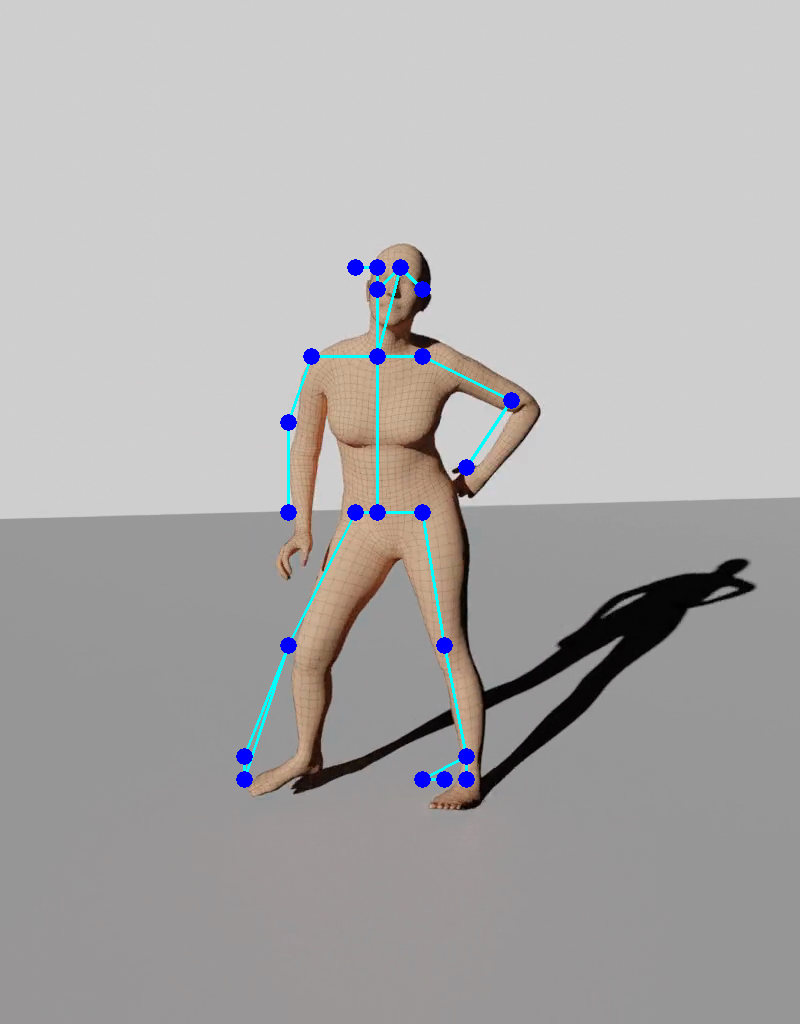

In [12]:
import cv2
import numpy as np
from tqdm import tqdm
from IPython.display import display, Image
import os
import time
import torch
# Load pre-trained OpenPose model

# Set root directory
root_dir = "C:\\Users\\avika\\OneDrive\\Documents\\UAL\\interactive_dance_thesis"
os.chdir(root_dir)


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

protoFile = "models/openpose_25/pose_deploy.prototxt"
weightsFile = "models/openpose_25/pose_iter_584000.caffemodel"
nPoints = 25


# Check if the files exist
if not os.path.exists(protoFile):
    print(f"Error: The file {protoFile} does not exist.")
if not os.path.exists(weightsFile):
    print(f"Error: The file {weightsFile} does not exist.")

t = time.time()
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

if device == "cpu":
    net.setPreferableBackend(cv2.dnn.DNN_TARGET_CPU)
    print("Using CPU device")
elif device == "gpu":
    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)
    print("Using GPU device")





# BODY_25 Pose Pairs
POSE_PAIRS = [[1,0], [1,2], [1,5], [2,3], [3,4], [5,6], [6,7], [1,8], [8,12], 
              [8,9], [9,10], [12,13], [13,14], [1,15], [1,16], [0,15], [0,16], 
              [15,17], [16,18], [14,21], [14,19], [19,20], [10,23], [10,22], 
              [22,23]]

threshold = 0.1

def draw_pose(frame, keypoints, threshold=0.1):
    for pair in POSE_PAIRS:
        partA = pair[0]
        partB = pair[1]
        if keypoints[partA] and keypoints[partB]:
            cv2.line(frame, keypoints[partA], keypoints[partB], (0, 255, 255), 2)
            cv2.circle(frame, keypoints[partA], 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)
            cv2.circle(frame, keypoints[partB], 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)
    return frame


def get_pose_keypoints(frame):
    frame_width = frame.shape[1]
    frame_height = frame.shape[0]
    
    inHeight = 368
    inWidth = int((inHeight / frame_height) * frame_width)
    inp_blob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight), (0, 0, 0), swapRB=False, crop=False)
    net.setInput(inp_blob)
    output = net.forward()
    keypoints = []
    for i in range(nPoints):
        prob_map = output[0, i, :, :]
        min_val, prob, min_loc, point = cv2.minMaxLoc(prob_map)
        x = (frame_width * point[0]) / output.shape[3]
        y = (frame_height * point[1]) / output.shape[2]
        if prob > threshold:
            keypoints.append((int(x), int(y)))
        else:
            keypoints.append(None)
    return keypoints


from tqdm import tqdm

def process_video(input_path, output_path, resize_factor=1.0):
    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    frame_width = int(cap.get(3) * resize_factor)
    frame_height = int(cap.get(4) * resize_factor)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

    processed_frames = []
    for _ in tqdm(range(total_frames), desc="Processing Video", unit="frame"):
        ret, frame = cap.read()
        if not ret:
            break

        frame_resized = cv2.resize(frame, (frame_width, frame_height))
        keypoints = get_pose_keypoints(frame_resized)
        output_frame = draw_pose(frame_resized.copy(), keypoints, threshold)
        
        out.write(output_frame)
        processed_frames.append(output_frame)

    cap.release()
    out.release()
    cv2.destroyAllWindows()

    return processed_frames


# Set the paths to your video file and output file
input_video_path =  "G:\\UAL_Thesis\\affective_computing_datasets\\DanceDBrenders\\DanceDB\\20131001_OliviaKyriakides\\Olivia_Excited_C3D_body.mp4" # Update this path
output_video_path = "output.mp4"

# Process the video and get processed frames
processed_frames = process_video(input_video_path, output_video_path)

# Display some of the processed frames
for frame in processed_frames[::len(processed_frames)//5]:  # Select 5 frames evenly spaced throughout the video
    display(Image(cv2.imencode('.png', cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))[1].tobytes()))


In [2]:
file = np.load("G:\\Downloads\\DanceDB_SMPLX\\DanceDB\\20120731_StefanosTheodorou\\Stefanos_2os_antrikos_karsilamas_C3D_stageii.npz")


In [ ]:
from human_body_prior.tools.omni_tools import copy2cpu as c2c

body_pose_hand = bm(**{k:v for k,v in body_parms.items() if k in ['pose_body', 'betas', 'pose_hand']})
body_pose_beta = bm(**{k:v for k,v in body_parms.items() if k in ['pose_body', 'betas']})

from human_body_prior.body_model.body_model import BodyModel

bm_fname = osp.join(support_dir, 'body_models/smplh/{}/model.npz'.format(subject_gender))
dmpl_fname = osp.join(support_dir, 'body_models/dmpls/{}/model.npz'.format(subject_gender))

num_betas = 16 # number of body parameters
num_dmpls = 8 # number of DMPL parameters

bm = BodyModel(bm_fname=bm_fname, num_betas=num_betas, num_dmpls=num_dmpls, dmpl_fname=dmpl_fname).to(comp_device)
faces = c2c(bm.f)

def vis_body_joints(fId = 0):
    joints = c2c(body_pose_hand.Jtr[fId])
    joints_mesh = points_to_spheres(joints, point_color = colors['red'], radius=0.005)

    mv.set_static_meshes([joints_mesh])
    body_image = mv.render(render_wireframe=False)
    show_image(body_image)

vis_body_joints(fId=0)

In [31]:
for b in file:
    print(b)

gender
surface_model_type
mocap_frame_rate
mocap_time_length
markers_latent
latent_labels
markers_latent_vids
trans
poses
betas
num_betas
root_orient
pose_body
pose_hand
pose_jaw
pose_eye
markers
labels
markers_obs
labels_obs
markers_sim
marker_meta
num_markers


In [32]:
file['pose_body']

array([[ 0.1133019 ,  0.05096415,  0.03278591, ...,  0.19133089,
        -0.05885191, -0.31035567],
       [ 0.11626089,  0.05131466,  0.03266753, ...,  0.19157358,
        -0.05904254, -0.30854001],
       [ 0.11978095,  0.05147315,  0.03246324, ...,  0.19224783,
        -0.0582863 , -0.30779574],
       ...,
       [ 0.07462463, -0.05835456,  0.11746063, ..., -0.00062255,
        -0.05106681,  0.03376832],
       [ 0.06201682, -0.05963991,  0.11681955, ...,  0.00539349,
        -0.04755541,  0.0290521 ],
       [ 0.04883798, -0.05932087,  0.11629105, ...,  0.01390477,
        -0.04447364,  0.02190129]])

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib.animation import FuncAnimation
%matplotlib notebook

file = np.load("G:\\Downloads\\DanceDB_SMPLX\\DanceDB\\20120731_StefanosTheodorou\\Stefanos_2os_antrikos_karsilamas_C3D_stageii.npz")


# Sample data: 10 frames, 25 keypoints (x, y, z)
data = file['pose_body']

num_frames, num_keypoints = data.shape[0], data.shape[1] // 3
keypoints = data.reshape(num_frames, num_keypoints, 3)

# Define connections based on the skeletal model
connections = [
    (0, 1), (1, 2), (2, 3), (3, 4),  # Spine and head
    (1, 5), (5, 6), (6, 7),  # Left arm
    (1, 8), (8, 9), (9, 10),  # Right arm
    (1, 11), (11, 12), (12, 13),  # Left leg
    (1, 14), (14, 15), (15, 16),  # Right leg
    (7, 17), (17, 18), (18, 19),  # Left hand
    (10, 20),  # Right hand
]
  # Define your connections here

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter([], [], [])
lines = [ax.plot([], [], [], 'k-')[0] for _ in connections]

def init():
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(-1, 1)
    return sc, *lines

def update(frame):
    sc._offsets3d = (keypoints[frame, :, 0], keypoints[frame, :, 1], keypoints[frame, :, 2])
    for line, (start, end) in zip(lines, connections):
        line.set_data(keypoints[frame, [start, end], 0], keypoints[frame, [start, end], 1])
        line.set_3d_properties(keypoints[frame, [start, end], 2])
    return sc, *lines

anim = FuncAnimation(fig, update, frames=num_frames, init_func=init, blit=True)
anim.save('keypoints_animation.mp4', writer='ffmpeg', fps=30)

<IPython.core.display.Javascript object>

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib.animation import FuncAnimation
%matplotlib notebook

# Sample data: 10 frames, 25 keypoints (x, y, z)
data = file['pose_body']

num_frames, num_keypoints = data.shape[0], data.shape[1] // 3
keypoints = data.reshape(num_frames, num_keypoints, 3)

# Update connections based on your actual data
connections = [...]  # Define your connections here

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter([], [], [])
lines = [ax.plot([], [], [], 'k-')[0] for _ in connections]

def init():
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_zlim(-2, 2)
    return sc, *lines

def update(frame):
    sc._offsets3d = (keypoints[frame, :, 0], keypoints[frame, :, 1], keypoints[frame, :, 2])
    for line, (start, end) in zip(lines, connections):
        line.set_data(keypoints[frame, [start, end], 0], keypoints[frame, [start, end], 1])
        line.set_3d_properties(keypoints[frame, [start, end], 2])
    return sc, *lines

ani = FuncAnimation(fig, update, frames=num_frames, init_func=init, blit=False)
plt.show()


<IPython.core.display.Javascript object>

In [41]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
%matplotlib notebook

# Sample data: 10 frames, 25 keypoints (x, y, z)
data = file['pose_body']

num_frames, num_keypoints = data.shape[0], data.shape[1] // 3
keypoints = data.reshape(num_frames, num_keypoints, 3)

# Visualize a single frame
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(keypoints[0, :, 0], keypoints[0, :, 1], keypoints[0, :, 2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Keypoints Visualization (Single Frame)')
ax.set_xlim(-2, 3)
ax.set_ylim(-2, 3)
ax.set_zlim(-2, 3)
plt.show()


<IPython.core.display.Javascript object>

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from tqdm import tqdm
import torch
import smplx

def load_npx_data(file_path):
    data = np.load(file_path, allow_pickle=True)
    return {key: data[key] for key in data.files}

def create_smplx_model(model_path):
    model = smplx.create(model_path, model_type='smplx', gender='neutral', ext='npz')
    return model

def plot_skeleton(ax, joints):
    ax.clear()
    connections = [
        # Head
        (0, 1), (1, 2), (2, 3), (3, 4),
        # Spine
        (4, 5), (5, 6), (6, 7), (7, 8),
        # Left Arm
        (8, 9), (9, 10), (10, 11), (11, 12),
        # Right Arm
        (8, 13), (13, 14), (14, 15), (15, 16),
        # Left Leg
        (8, 17), (17, 18), (18, 19), (19, 20),
        # Right Leg
        (8, 21), (21, 22), (22, 23), (23, 24),
    ]
    
    for connection in connections:
        start, end = connection
        xs = [joints[start, 0], joints[end, 0]]
        ys = [joints[start, 1], joints[end, 1]]
        zs = [joints[start, 2], joints[end, 2]]
        ax.plot(xs, ys, zs, 'k-')
    
    ax.scatter(joints[:, 0], joints[:, 1], joints[:, 2], c='r', marker='o')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

def update(frame):
    joints = output.joints[frame].detach().numpy()
    plot_skeleton(ax, joints)
    pbar.update(1)

if __name__ == "__main__":
    file_path = "G:\\Downloads\\DanceDB_SMPLX\\DanceDB\\20120731_StefanosTheodorou\\Stefanos_2os_antrikos_karsilamas_C3D_stageii.npz"
    model_path = "G:\\Downloads\\smplx_lockedhead_20230207\\models_lockedhead\\smplx\\SMPLX_FEMALE.npz"
    
    data = load_npx_data(file_path)
    model = create_smplx_model(model_path)
    
    # Set SMPL-X parameters
    # Set the model parameters
    body_pose = torch.tensor(data['pose_body'], dtype=torch.float32)
    betas = torch.tensor(data['betas'], dtype=torch.float32)
    global_orient = torch.tensor(data['root_orient'], dtype=torch.float32)
    transl = torch.tensor(data['trans'], dtype=torch.float32)
    
    betas = betas.unsqueeze(0)
    body_pose = body_pose.unsqueeze(0)
    global_orient = global_orient.unsqueeze(0)
    transl = transl.unsqueeze(0)
    
    # Forward pass to get the output
    output = model(betas=betas, body_pose=body_pose, global_orient=global_orient,  transl=transl)
    
    # Extract the 3D joint coordinates
    joints = output.joints.detach().numpy().squeeze()
    
    num_frames = output.joints.shape[0]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    pbar = tqdm(total=num_frames, desc='Animating')
    ani = FuncAnimation(fig, update, frames=num_frames, repeat=False)
    plt.show()
    pbar.close()


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 5837 but got size 1 for tensor number 2 in the list.

In [16]:
for d in data:
    print(d)

gender
surface_model_type
mocap_frame_rate
mocap_time_length
markers_latent
latent_labels
markers_latent_vids
trans
poses
betas
num_betas
root_orient
pose_body
pose_hand
pose_jaw
pose_eye
markers
labels
markers_obs
labels_obs
markers_sim
marker_meta
num_markers
